In [9]:
import shutil
import sys
from pathlib import Path
from pprint import pprint
from timeit import default_timer

import torch
import tqdm
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import Cityscapes
from torchvision.models.segmentation import fcn_resnet50
from torchvision.transforms.v2 import functional as TF

sys.path.append(str(Path("..").resolve()))
from src.pixseg.datasets import *
from src.pixseg.models import *
from src.pixseg.pipeline import (
    TestTimeAugmentations,
    create_snapshots,
    eval_one_epoch,
    inference_with_augmentations,
    inference_with_sliding_window,
)
from src.pixseg.utils.metrics import MetricStore
from src.pixseg.utils.rng import seed
from src.pixseg.utils.transform import SegmentationAugment, SegmentationTransform
from src.pixseg.utils.visual import combine_images

In [10]:
metadata = resolve_metadata("VOC")
transforms = SegmentationTransform(mask_fill=metadata.ignore_index)
augment = SegmentationAugment(mask_fill=metadata.ignore_index)
dataset = DATASET_ZOO["VOC"].construct_val(transforms, root=r"..\dataset", year="2007")
data_loader = DataLoader(dataset)

In [11]:
## load model from file
# model_state_file = Path(r"..\runs\20250227_171651\best_model.pth")
# model = deeplabv3_resnet18(num_classes=metadata.num_classes)
# model_weights = torch.load(model_state_file)
# model.load_state_dict(model_weights)

## or from pretrained weights
model = bisenet_resnet18(weights=BiSeNet_ResNet18_Weights.SBD)

In [12]:
criterion = nn.CrossEntropyLoss(ignore_index=metadata.ignore_index)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()
criterion.to(device).eval()
print(device)

cpu


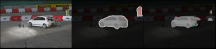

In [13]:
snapshots = create_snapshots(model, dataset, augment, device, metadata.colors)
combined = combine_images([s for ss in snapshots for s in ss])
combined_pil: Image.Image = TF.to_pil_image(combined)
combined_pil.reduce(7)

### Without augmentations

In [14]:
seed(42)
ms = eval_one_epoch(
    model, data_loader, augment, criterion, device, metadata.num_classes
)
pprint(ms.summarize())

Eval: 100%|██████████| 213/213 [00:20<00:00, 10.52it/s, acc=0.926, macc=0.8, miou=0.673, fwiou=0.87, dice=0.791, loss=0.273, time=0.0737]    

{'acc': 0.9262985526066942,
 'dice': 0.7908804631579106,
 'fwiou': 0.8698076158034788,
 'loss': 0.2734202510270644,
 'macc': 0.800131975972541,
 'miou': 0.6730587339177458,
 'time': 0.07372506525823322}


### With augmentations

In [15]:
scales = (0.5, 0.75, 1.0, 1.25, 1.5)
ttas = TestTimeAugmentations(scales, (False, True), iter_product=True)

In [16]:
seed(42)
ms = MetricStore(metadata.num_classes)
loader = tqdm.tqdm(iter(data_loader), total=len(data_loader))
for images, masks in loader:
    start_time = default_timer()
    prelim_images, masks = augment(images.to(device), masks.to(device))
    augmented_logits = inference_with_augmentations(model, prelim_images, ttas)

    # may change how to aggregate results
    aggregated_logits = torch.mean(augmented_logits, dim=0)
    loss = criterion(aggregated_logits, masks)
    end_time = default_timer()

    preds = aggregated_logits.argmax(1)
    ms.store_results(masks, preds)
    batch_size = images.size(0)
    measures = {
        "loss": loss.item() * batch_size,
        "time": end_time - start_time,
    }
    ms.store_measures(batch_size, measures)
    loader.set_postfix(ms.summarize())
pprint(ms.summarize())

100%|██████████| 213/213 [03:48<00:00,  1.07s/it, acc=0.933, macc=0.773, miou=0.699, fwiou=0.877, dice=0.806, loss=0.237, time=1.05]   

{'acc': 0.9332198056677723,
 'dice': 0.8062402011455987,
 'fwiou': 0.876810739398423,
 'loss': 0.23652208976648714,
 'macc': 0.7731211764653614,
 'miou': 0.6994119460255886,
 'time': 1.045327307981161}


### With sliding window

In [17]:
window_size = (128, 256)

In [18]:
seed(42)
ms = MetricStore(metadata.num_classes)
loader = tqdm.tqdm(iter(data_loader), total=len(data_loader))
for images, masks in loader:
    start_time = default_timer()
    prelim_images, masks = augment(images.to(device), masks.to(device))
    augmented_logits = inference_with_sliding_window(model, prelim_images, window_size)
    aggregated_logits = torch.mean(augmented_logits, dim=0)
    end_time = default_timer()

    preds = aggregated_logits.argmax(1)
    ms.store_results(masks, preds)
    batch_size = images.size(0)
    measures = {"time": end_time - start_time}
    ms.store_measures(batch_size, measures)
    loader.set_postfix(ms.summarize())
pprint(ms.summarize())

100%|██████████| 213/213 [00:52<00:00,  4.03it/s, acc=0.8, macc=0.302, miou=0.247, fwiou=0.656, dice=0.376, time=0.225]   

{'acc': 0.799742103204781,
 'dice': 0.3761293807774655,
 'fwiou': 0.6555108394801383,
 'macc': 0.30177461685984663,
 'miou': 0.24720618217619106,
 'time': 0.22538711126752203}


### For submitting to cityscapes benchmark suite

In [ ]:
assert isinstance(dataset, Cityscapes)
out_folder = Path(r"cityscapes_semantic")
out_folder.mkdir(parents=True)
full_metadata = resolve_metadata("CityscapesFull")

ttas = TestTimeAugmentations((1,), (False, True), (False,), (0,), iter_product=True)
loader = tqdm.tqdm(enumerate(data_loader), total=len(data_loader))
for i, (images, masks) in loader:
    prelim_images, masks = augment(images.to(device), masks.to(device))
    augmented_logits = inference_with_augmentations(model, prelim_images, ttas)
    aggregated_logits = torch.mean(augmented_logits, dim=0)

    # convert preds to labelIDs
    preds = aggregated_logits.argmax(1)
    label_id_pred = torch.zeros_like(preds, dtype=torch.uint8)
    for train_id, train_label in enumerate(metadata.labels):
        if train_label in full_metadata.labels:
            label_id = full_metadata.labels.index(train_label)
            label_id_pred[preds == train_id] = label_id

    image_path = Path(dataset.images[i])
    preds_pil: Image.Image = TF.to_pil_image(label_id_pred)
    palette = [c for rgb in full_metadata.colors for c in rgb]
    preds_pil.putpalette(palette)
    preds_pil.save(out_folder / image_path.with_suffix(".png").name)

shutil.make_archive("cityscapes_semantic", "zip", out_folder)